Рекуррентные нейронные сети могут использоваться для разных задач: один ко многим, многие к одному, многие ко многим. В последнем случае длина входной и выходной последовательности либо должна быть одинаковой, либо может быть произвольной.

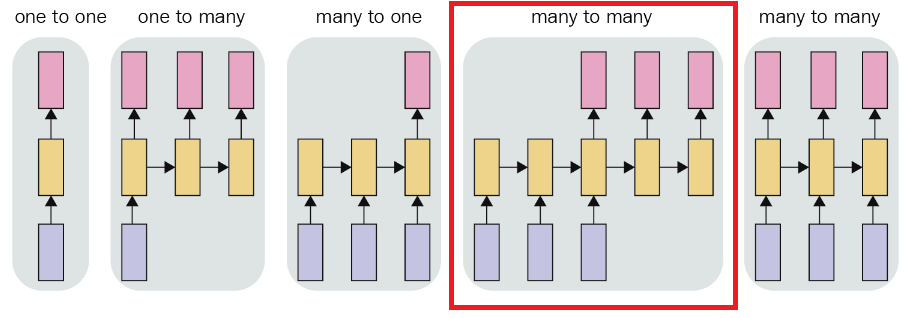

Для преобразования одной последовательности в другую, длина которых может быть любой и не обязательно должна совпадать, используются модели **Sequence-to-sequence (seq2seq)**.

## Модель Sequence-to-sequence и машинный перевод

Одна из распространенных задач, где используются модели seq2seq, — машинный перевод.

Для перевода текста можно разбить исходное предложение на несколько фрагментов, затем переводить его по фразам. 

📌 Какие проблемы есть у такого подхода?

Другая возможность — прочитать все исходное предложение целиком, проанализировать его значение, а затем произвести перевод.



Рассмотрим задачу перевода с английского на французский язык:
- Исходное предложение: I am a student.
- Целевое предложение: Je suis étudiant.

Модель seq2seq состоит из двух рекуррентных нейронных сетей:
- энкодер: строит векторное представление для исходного предложения (кодирует)
- декодер: генерирует целевое предложение на основе этого векторного представления (раскодирует)

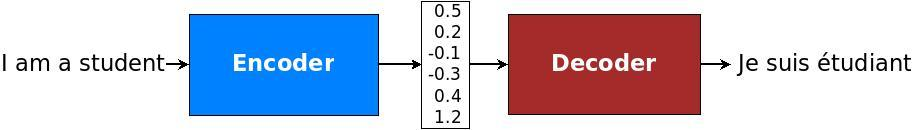

Ниже представлена более подробная схема. Синим обозначен блок энкодера, красным — блок декодера.

Архитектура энкодера:
- на вход первой ячейки RNN поступает вектор слова "I" и нулевое скрытое состояние, 
- вектор слова "I" обрабатывается внутри первой ячейки RNN;
- на вход второй ячейки поступает вектор слова "am" и измененный вектор слова "I" как скрытое состояние;
- вектор слова "am" обрабатывается внутри второй ячейки RNN;
- $\cdots$
- вектор слова "student" обрабатывается внутри четвертой ячейки RNN;
- измененный вектор слова "student" (= вектор предложения) поступает на вход декодера как скрытое состояние.

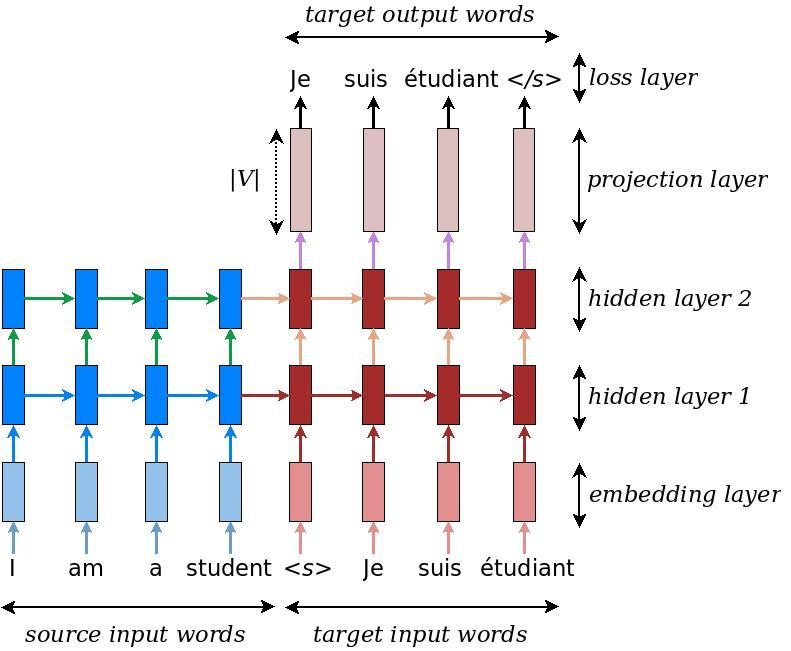

Архитектура декодера:
- входная последовательность: спецсимвол начала + целевое предложение
- выходная последовательность: целевое предложение + спецсимвол конца
- на вход первой ячейки RNN поступает вектор спецсимвола начала предложения и вектор исходного предложения из энкодера как скрытое состояние;
-  вектор спецсимвола начала предложения обрабатывается внутри первой ячейки RNN;
- на вход второй ячейки поступает вектор слова "Je" и измененный вектор спецсимвола начала как скрытое состояние;
- вектор слова "Je" обрабатывается внутри второй ячейки RNN;
- $\cdots$
- вектор слова "étudiant" обрабатывается внутри четвертой ячейки RNN;
- измененные векторы каждого слова передаются на линейный слой, применяется softmax;
- на выходе получаем 4 вектора, длина которых равна длине словаря, — это распределение вероятностей для следующего элемента при условии текущей последовательности.

📌 На что похожа работа декодера?

Энкодер используется для получения конекстуализированного вектора исходного предложения. Декодер используется для генерации целевого предложения. При этом вектор исходного предложения используется в качестве скрытого состояния на первом шаге генерации. В отличие от задачи языкового моделирования, где генерируется наиболее вероятная последовательность, декодер генерирует целевое предложение с учетом контекста в виде исходного предложения.

📌 Почему передавать вектор исходного предложения только в первую ячейку может быть не очень хорошо?

## Механизм внимания

Механизм внимания (attention mechanism) используется для поиска взаимосвязей между различными частями входных и выходных данных. Он был предложен в статье [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473).

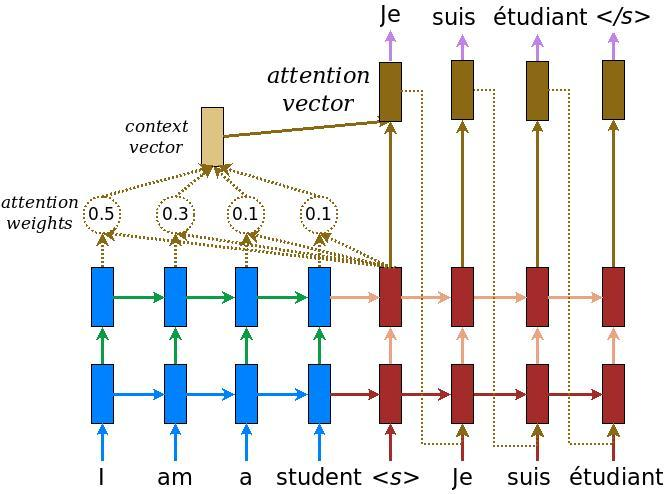

Архитектура энкодера не меняется, все изменения касаются архитектуры декодера. 
- на вход первой ячейки RNN также поступает вектор спецсимвола начала предложения и вектор исходного предложения из энкодера как скрытое состояние;
-  вектор спецсимвола начала предложения обрабатывается внутри первой ячейки RNN;
- для вектора спецсимвола начала предложения и векторов каждого слова исходной последовательности считается мера сходства — это и есть веса внимания (attention weights);
- если векторы некоторого слова целевого и исходного предложения схожи, то при переводе (генерации) данного слова декодер больше "обращает внимания" на него;
- вектор каждого слова исходного предложения умножается на свой вес внимания, затем все векторы складываются, получаем контекстный вектор (context vector);
- вектор спецсимвола начала предложения и контекстный вектор конкатенируются;
- конкатенированный вектор передается на линейный слой, применяется softmax;
- получаем вектор, длина которого равна длине словаря, — это распределение вероятностей для следующего элемента при условии спецсимвола начала предложения;
- на вход второй ячейки поступает вектор слова "Je" и измененный вектор спецсимвола начала как скрытое состояние;
- вектор слова "Je" обрабатывается внутри второй ячейки RNN;
- считаются веса внимания для слова "Je" и всех слов целевого предложения;
- $\cdots$
- для каждого слова получаем распределение вероятностей.

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">


## Модель seq2seq с механизмом внимания для перевода

Создадим свою модель seq2seq, которая будет использовать механизм внимания. Будем использовать ее для перевода с английского на французский.

### Загрузка и обработка данных



Загрузим данные. Будем использовать пары предложений проекта [Tatoeba](https://tatoeba.org/ru), доступные [по ссылке](https://www.manythings.org/anki/).

In [ ]:
!wget https://raw.githubusercontent.com/Xeanst/NN_in_compling/main/07_attention/eng-fra.txt

--2023-04-27 17:04:30--  https://raw.githubusercontent.com/Xeanst/NN_in_compling/main/07_attention/eng-fra.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9541158 (9.1M) [text/plain]
Saving to: ‘eng-fra.txt’

eng-fra.txt         100%[===================>]   9.10M  --.-KB/s    in 0.07s   

2023-04-27 17:04:31 (127 MB/s) - ‘eng-fra.txt’ saved [9541158/9541158]



In [ ]:
!head eng-fra.txt

Go.	Va !
Run!	Cours !
Run!	Courez !
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !
Jump.	Saute.
Stop!	Ça suffit !
Stop!	Stop !
Stop!	Arrête-toi !


Создадим класс `Lang` для создания словаре `word2id` и `id2word` для каждого языка. Добавим в него спецсимволы начала и конца последовательности.

In [ ]:
BOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2id = {}
        self.id2word = {0: "<BOS>", 1: "<EOS>"}
        self.n_words = 2

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2id:
            self.word2id[word] = self.n_words
            self.id2word[self.n_words] = word
            self.n_words += 1

Напишем функцию для нормализации, которая приводит слова к нижнему регистру и удаляет знаки препинания.

In [ ]:
import re
def normalizeString(s):
    s = ''.join(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

Создадим функцию для чтения файла и разделения данных двух языков. Разделим файл на строки, а потом разделим строки на пары.

In [ ]:
def readLangs(lang1, lang2):

    # Читаем файл и делим на строки
    lines = open('eng-fra.txt', encoding='utf-8').\
        read().strip().split('\n')

    # Разделяем каждую строку на два предложения и применяем нормализацию
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Распределяем предложения по языкам
    pairs = [list(p) for p in pairs]
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Будем использовать только предложения, длина которых меньше заданной длины. Для английского выберем предложения, которые начинаются со слов из заданного списка.

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[0].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

Объединим все функции в одну.

- Читаем файл, делим на строки и на пары;
- Нормализуем текст, фильтруем по длине и по содержанию;
- Записываем пары предложений в список.

In [ ]:
def prepareData(lang1, lang2):
    input_lang, output_lang, pairs = readLangs(lang1, lang2)
    print(f"{len(pairs)} пар предложений всего")
    pairs = filterPairs(pairs)
    print(f"{len(pairs)} пар предложений после фильтрации ")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Количество слов:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [ ]:
import random
input_lang, output_lang, pairs = prepareData('eng', 'fra')
print(random.choice(pairs))

135842 пар предложений всего
10177 пар предложений после фильтрации 
Количество слов:
eng 2728
fra 3899
['she s an honest girl .', 'c est une fille honn te .']


Для обучения модели нужно перевести предложения в тензоры, сопоставив каждому слову его индекс. При создании этих векторов мы добавим токен EOS к обеим последовательностям. Для этого будем использовать функцию `tensorFromSentence`. Также создадим функцию `tensorsFromPair`, которая преобразует пары в набор входных и выходных данных.

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
def tensorFromSentence(lang, sentence):
    indexes = [lang.word2id[word] for word in sentence.split(' ')]
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [ ]:
print(pairs[0])
input_tensor, target_tensor = tensorsFromPair(pairs[0])
print(input_tensor)
print(input_tensor.shape)
print(target_tensor)
print(target_tensor.shape)

['i m .', 'j ai ans .']
tensor([[2],
        [3],
        [4],
        [1]], device='cuda:0')
torch.Size([4, 1])
tensor([[2],
        [3],
        [4],
        [5],
        [1]], device='cuda:0')
torch.Size([5, 1])


### Создание модели

Создадим модель seq2seq, состоящую из двух рекуррентных нейронных сетей: энкодера и декодера (простого или с механизмом внимания). Для каждой сети будет использоваться свой класс.

#### Энкодер

Энкодер проходит по исходной последовательности и для каждого слова создает контекстуализированный вектор, который также передается в качестве скрытого состояния. Вектор для последнего слова также является вектором всего предложения. 

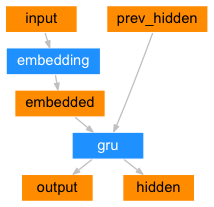

In [ ]:
import torch.nn as nn
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        # input: 1
        # hidden: 1 x 1 x hidden_size

        embedded = self.embedding(input).view(1, 1, -1)
        # embedded: 1 x 1 x hidden_size

        output = embedded
        output, hidden = self.gru(output, hidden)
        # output: 1 x 1 x hidden_size
        # hidden: 1 x 1 x hidden_size

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### Декодер

В простом случае декодер использует только последний выход энкодера — вектор всего предложения (контекстный вектор). Он используется в качестве скрытого состояния для первой ячейки декодера.

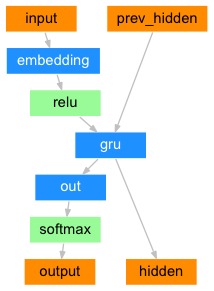

In [ ]:
import torch.nn.functional as F

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # input: 1 x 1
        # hidden: 1 x 1 x hidden_size

        output = self.embedding(input).view(1, 1, -1)
        # output: 1 x 1 x hidden_size

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        # output: 1 x 1 x hidden_size
        # hidden: 1 x 1 x hidden_size

        output = self.softmax(self.out(output[0]))
        # output: 1 x 1 x hidden_size

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### Декодер с механизмом внимания

Если передавать контекстный вектор только в первую ячейку, информация об исходном предложении постепенно "теряется" при проходе по целевому предложению. Механизм внимания позволяет каждой ячейке декодера (каждому слову целевой последовательности) "фокусироваться" на выходах разных ячеек энкодера (разных словах исходной последовательности).

Сначала вычисляются веса внимания (`attn_weights`). Они умножаются на выходные векторы энкодера. Результат (`attn_applied`) должен содержать информацию о том, насколько каждое слово входной последовательности важно для перевода текущего слова целевой последовательности.

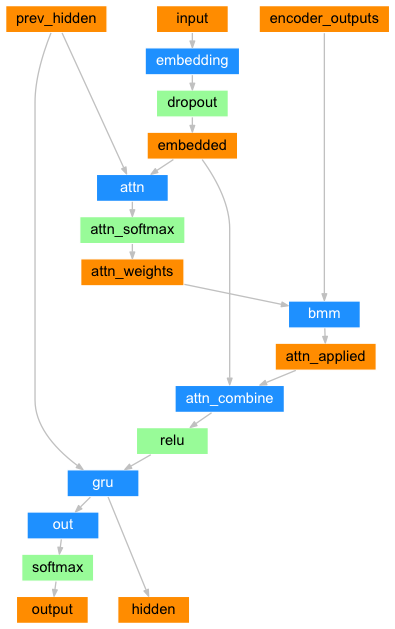

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        # input: 1 x 1
        # hidden: 1 x 1 x hidden_size
        # encoder_outputs: max_length x hidden_size

        embedded = self.embedding(input).view(1, 1, -1)
        # embedded: 1 x 1 x hidden_size
        embedded = self.dropout(embedded)
        # embedded: 1 x 1 x hidden_size

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        # attn_weights: 1 x max_length
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        # attn_applied: 1 x max_length

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        # output: 1 x hidden_size*2
        output = self.attn_combine(output).unsqueeze(0)
        # output: 1 x 1 x hidden_size

        output = F.relu(output)
        # output: 1 x 1 x hidden_size
        output, hidden = self.gru(output, hidden)
        # output: 1 x 1 x hidden_size
        # hidden: 1 x 1 x hidden_size

        output = F.log_softmax(self.out(output[0]), dim=1)
        # output: 1 x output_size
        
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Обучение

При обучении модели исходная последовательность поступает на вход энкодера, на выходе энкодера — контекстуализированные векторы каждого слова и вектор всего предложения (последнего слова). На вход декодера поступает вектор исходного предложения как скрытое состояние и спецсимвол начала последовательности.

Для обучения декодера будем использовать метод ускорения с учителем (teacher forcing). Во время обучения на каждом следующем шаге модель получает на вход не наиболее вероятный токен в соответствии с полученным распределением вероятностей, а правильный токен из целевой последовательности.

In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[BOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # ускорение с учителем: на вход подаются токены целевого предложения
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]

    else:
        # на вход подаются предсказания декодера
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

Напишем вспомогательные функции для отображения того, сколько времени потрачено на обучение и сколько осталось потратить. 

Функция `asMinutes` возвращает количество минут и секунд. Для подсчета полных минут количество секунд делится на 60 и округляется в меньшую сторону. Затем вычисляется оставшееся количество секунд.

Функция `timeSince` считает потраченное и оставшееся время. Для подсчета потраченного времени из текущего времени вычитается время начала обучения. Для подсчета оставшегося времени результат делится на долю прошедших эпох среди всех эпох, из него вычитается потраченное время.

In [ ]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
from torch import optim

def trainIters(encoder, decoder, n_iters, print_every=1000, learning_rate=0.01):
    start = time.time()
    print_loss_total = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

1m 37s (- 22m 51s) (5000 6%) 3.4598
3m 4s (- 19m 57s) (10000 13%) 2.8737
4m 31s (- 18m 5s) (15000 20%) 2.5173
5m 59s (- 16m 27s) (20000 26%) 2.2275
7m 26s (- 14m 52s) (25000 33%) 2.0135
8m 52s (- 13m 19s) (30000 40%) 1.8365
10m 20s (- 11m 49s) (35000 46%) 1.6520
11m 47s (- 10m 19s) (40000 53%) 1.5381
13m 14s (- 8m 49s) (45000 60%) 1.4185
14m 43s (- 7m 21s) (50000 66%) 1.3497
16m 10s (- 5m 52s) (55000 73%) 1.2585
17m 38s (- 4m 24s) (60000 80%) 1.1670
19m 7s (- 2m 56s) (65000 86%) 1.1138
20m 36s (- 1m 28s) (70000 93%) 1.0418
22m 6s (- 0m 0s) (75000 100%) 0.9915


### Тестирование

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[BOS_token]], device=device)

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.id2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

> they are our guests .
= ils sont nos invit s .
< elles sont nos invit s . <EOS>

> i m kind of happy .
= je suis assez heureux .
< je suis assez heureux . <EOS>

> you re going to be a father .
= tu vas tre p re .
< vous vas vous faire . <EOS>

> you re not allowed to eat those .
= tu n es pas autoris manger ceux ci .
< vous n tes pas autoris manger ceux l . <EOS>

> i am off duty tomorrow .
= je suis libre demain .
< je ne suis pas demain demain . <EOS>

> you re such a liar .
= quelle menteuse vous faites !
< quelle menteuse tu tu fais ! <EOS>

> we re back together .
= nous sommes de nouveau ensemble .
< nous sommes de retour . <EOS>

> i m ready to start .
= je suis pr t d marrer .
< je suis pr t pour d . <EOS>

> we re not cops .
= nous ne sommes pas flics .
< nous ne sommes des flics . <EOS>

> we re not looking .
= nous sommes pas en train de regarder .
< nous ne allons pas . <EOS>

